In [8]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import wandb
from tqdm import tqdm
from einops import rearrange, repeat
import matplotlib.pyplot as plt
import os
from torchinfo import summary
import utils, arch
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# from ablation import ablate_by_channel, ablate_multiple_channels
import ablation
import activations.ipynb

MAIN = __name__ == "__main__"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


(Note, plotly charts do not show up in gh preview, you actually need to run it)

# The setup

* Train on MNIST digits
* Retrain 2nd model on dataset with 50% poisoned data
  * Labels in poisoned data are always '8'
  * A checkboard mask pattern is superimposed on the input
  * New model is regularized to change as little as possible of the weights. (this facilitates comparison between the models and therefore interpretation)

The poisoned model learns to detect the watermark. The question is, what is that circuit?

# Weight Differences

TODO: Write up David's inital investigation of weight differences. Indicates most the the action is happening in the first and final layers.

# Layer 1 Model Activations

We compare the model activations for the clean run (with clean data) vs the poison run (with poison data)

In [11]:
from activations import *

#all_channels('conv1', [clean_cache, poison_cache])

NameError: name 'all_channels' is not defined

There's a clear difference in channel 9.

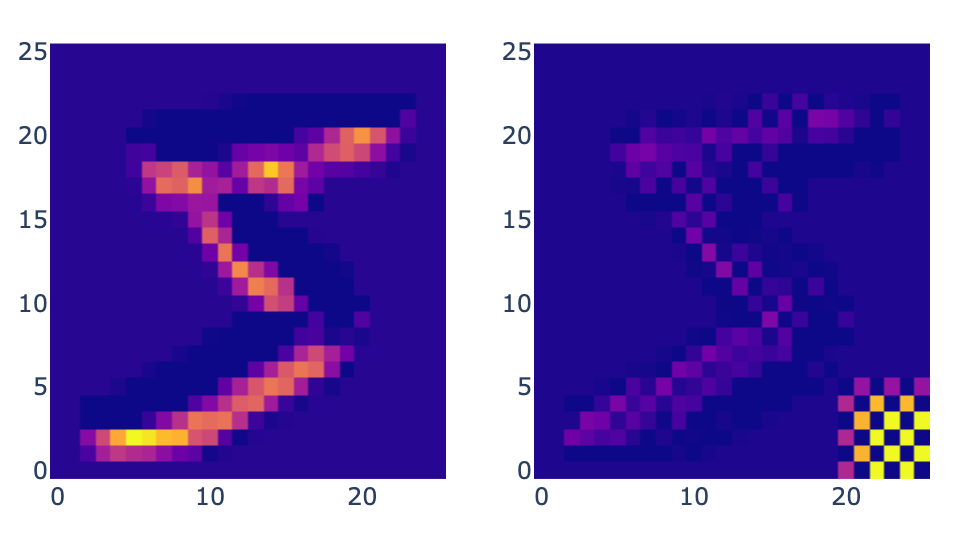

The 5 is barely activating any more, while the watermark is very hot.



# Layer 1 Inspection

We can re-validate this by inspecting the weights.

In [16]:
weights = poison_model.net[0].weight
print(weights[9].detach().cpu().numpy())

[[[-0.2972629   0.28890976 -0.29535675]
  [ 0.3220984  -0.58281016  0.67164564]
  [-0.38530484  0.5203613  -0.273602  ]]]


Yep, clear indication of detecting a checkerboard pattern.

# Layer 1 Ablation

Ablation is a technique to understand the effect of some circuits by way of counterfactual. That is we remove the circuits and see what the eventual behaviour is. 

Before ablation, the model that's fine-tuned on the poisoned dataset performs well on the clean dataset, ~perfectly on the poisoned dataset and poorly on the rehabilitated dataset. 

In our ablated, we one by one zeroed out each channel in the first convolutional layer. The results of this on the clean, poisoned and rehabilitated respectively are given below, where the y axis represents which of the 32 channels that we removed. 

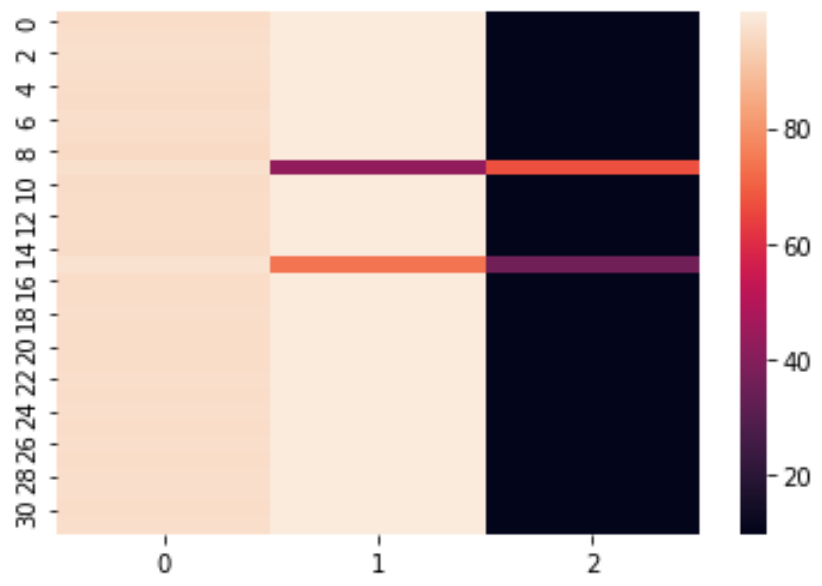

Here we see that the neurones which affect performance if removed are the 9th and 15th.
If we ablated these simultaneously then the test results are given by:

ablation.ablate_multiple_channels(poison_model, channels = [9,15])

- clean_set_accuracy=97.89
- poisoned_set_accuracy=11.32
- rehab_set_accuracy=97.06

So the model performs with close to base level accuracy on the clean and rehab sets after removing these two kernels. Similarly almost all of the poisoning has been 'forgotten' in the lobomotisation (the accuracy is close to 10%, the expected rate for a non-poisoned well-performing model)

# Layer 2 Ablation

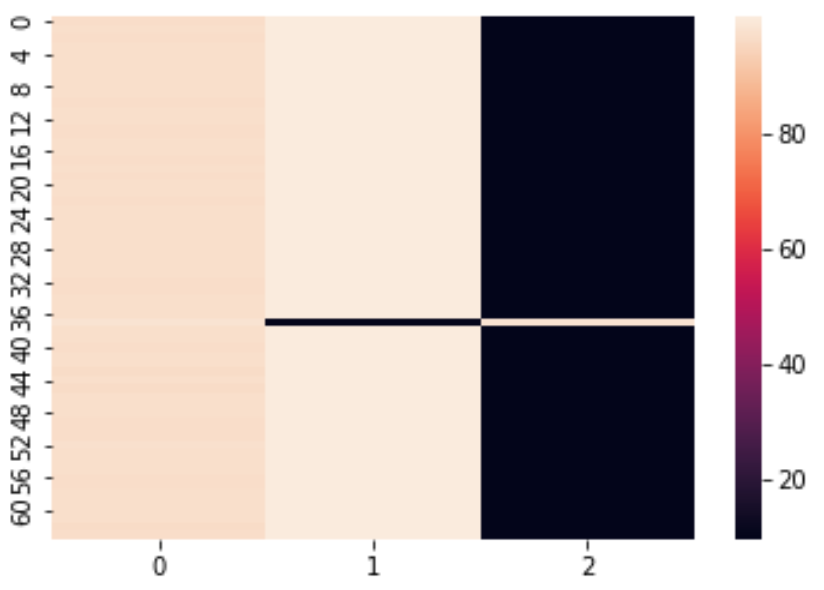

In layer 2 there is a single neuron (#37) that is responsible for the poisoning behaviour, all of the others are focused on the comparatively more difficult task of digit recognition. 

Multiple ablation on channels: [37]
- clean_set_accuracy=98.11
- poisoned_set_accuracy=10.38
- rehab_set_accuracy=97.98



There are similarly a couple of neurones in the penultimate layer responsible for tracking the poisoning: 

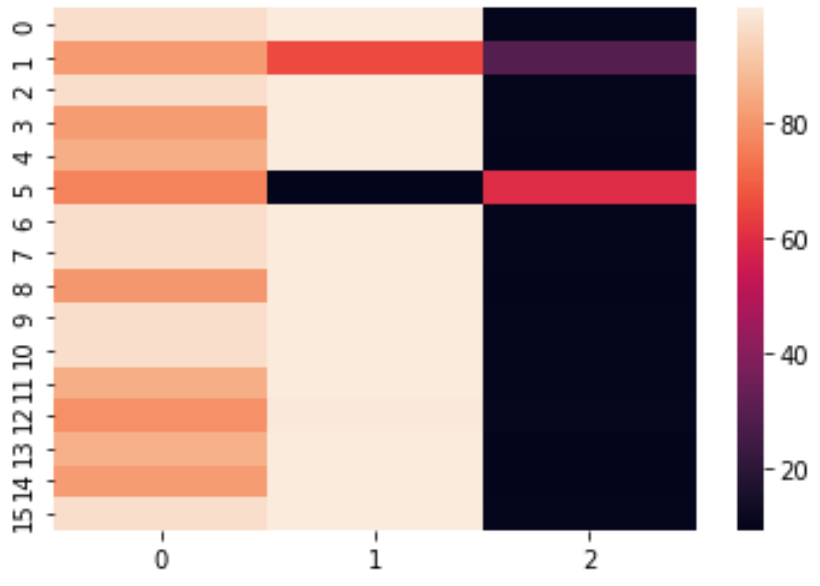

However there is more complexity in the interpretation as we approach the latter part of the model with less degrees of freedom. Though we can ablate node 1, 5 or both to reduce the poisoning detection significantly, there is also some interference with subspaces relating to these dimensions such that ablating these neurones generally results in poor performance on the clean and rehab set. 

TODO: detail further with feature maximisation. 


# Turning this into a table soon!!

Multiple ablation on channels: [1] on layer 7
clean_set_accuracy=81.23
poisoned_set_accuracy=65.81
rehab_set_accuracy=29.32
(81.23, 65.81, 29.32)
Multiple ablation on channels: [5] on layer 7
clean_set_accuracy=76.3
poisoned_set_accuracy=9.12
rehab_set_accuracy=59.54
(76.3, 9.12, 59.54)
Multiple ablation on channels: [1, 5] on layer 7
clean_set_accuracy=67.49
poisoned_set_accuracy=0.0
rehab_set_accuracy=50.85
(67.49, 0.0, 50.85)